In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import trange
from skimage.filters import threshold_li
from gasp import dataset, responses, gasp as GASP


M = dataset.load_dataset0()

Data: 20190401_GASP_PHANTOM data exists
pymapVBVD version 0.4.8
Software version: VB


Scan 1/1, read all mdhs:   0%|          | 0.00/136M [00:00<?, ?B/s]

read data:   0%|          | 0/16383 [00:00<?, ?it/s]

pymapVBVD version 0.4.8
Software version: VB


Scan 1/1, read all mdhs:   0%|          | 0.00/136M [00:00<?, ?B/s]

read data:   0%|          | 0/16383 [00:00<?, ?it/s]

pymapVBVD version 0.4.8
Software version: VB


Scan 1/1, read all mdhs:   0%|          | 0.00/136M [00:00<?, ?B/s]

read data:   0%|          | 0/16383 [00:00<?, ?it/s]

In [2]:
M = M.transpose(1,0,2,3,4)
M.shape #[Height, Width, Coil, PCs, TRs]

(128, 128, 4, 16, 3)

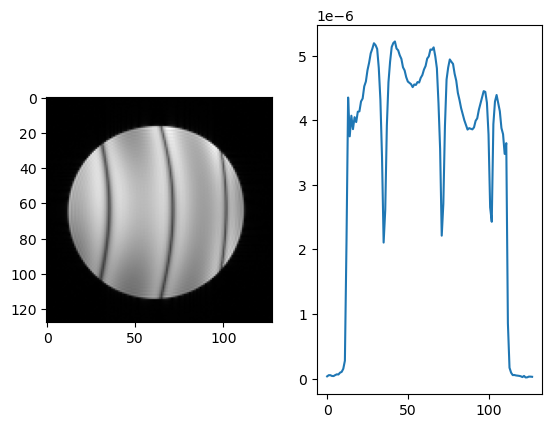

In [10]:
_ = np.sqrt(np.sum(np.abs(M)**2, axis=2))
_ = abs(_[:,:,0,0])
xx, yy = _.shape[:2]

plt.subplot(1, 2, 1)
plt.imshow(_, cmap='gray')
plt.subplot(1, 2, 2)
plt.plot(_[int(xx/2), :])
plt.show()

In [4]:
# Create mask of phantom
_ = np.sqrt(np.sum(np.abs(M)**2, axis=2))
_ = np.mean(_, axis=2)
_ = np.mean(_, axis=2)
_ = abs(_)
thresh = threshold_li(_)
mask = np.abs(_) > thresh
print(mask.shape)

# Apply mask to data
mask0 = np.tile(
    mask, (M.shape[2:] + (1, 1,))).transpose((3, 4, 0, 1, 2))
data = M * mask0
print(data.shape)

(128, 128)
(128, 128, 4, 16, 3)


In [5]:
data = np.reshape(data, data.shape[:-2] + (-1,))    # [Height, Width, Coil, PCs x TRs]
data = np.moveaxis(data, 2, 0)                      # [Coil, Height, Width, PCs x TRs]
data = data.transpose((0, 3, 2, 1))                 # [Coil,  PCs x TRs, Width,   Height]
print(data.shape)

# Get new dimensions
ncoils, npcs, height, width = data.shape[:]

# Calibration box - (# Number of lines of calibration, Pixels on signal)
C_dim = (32, width)

(4, 48, 128, 128)


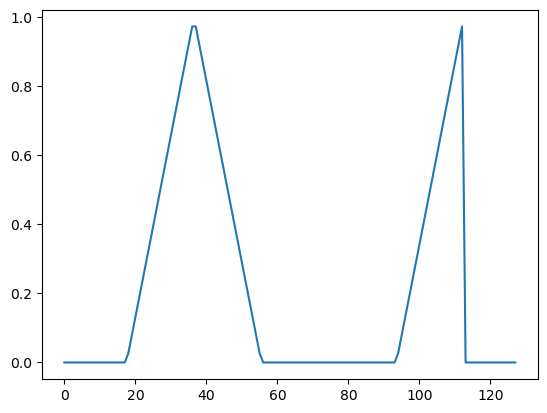

In [6]:
# Create forcing function
D = responses.triangle_periodic(width, 76, 18, 38)
D *= mask.T[int(height/2), :]
plt.plot(D)
plt.show()

In [7]:
Ic = np.zeros((ncoils, height, width), dtype='complex')
for cc in trange(ncoils, leave=False):
    Ic[cc, ...] = GASP.gasp(data[cc, ...], D, C_dim, pc_dim=0)
Ic = np.sqrt(np.sum(np.abs(Ic)**2, axis=0))
# Ic = np.abs(Ic[2, ...])

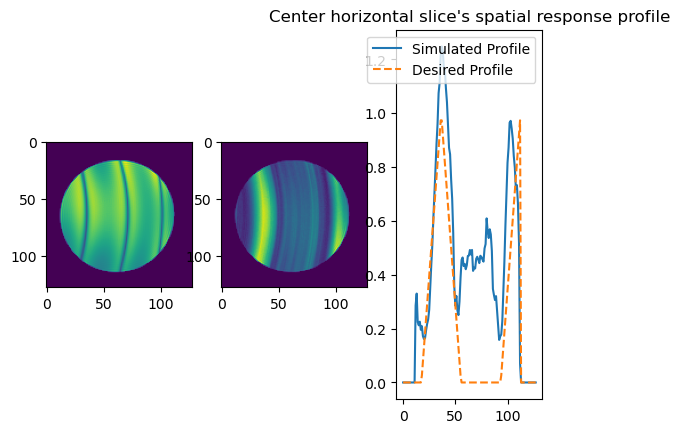

In [8]:
plt.subplot(1, 3, 1)
plt.imshow(np.sqrt(np.sum(abs(data[:, 0, ...])**2, axis=0)))

plt.subplot(1, 3, 2)
plt.imshow(Ic)

plt.subplot(1, 3, 3)
plt.plot(np.abs(Ic[int(height/2), :]), label='Simulated Profile')
plt.plot(D, '--', label='Desired Profile')
plt.legend()
plt.title('Center horizontal slice\'s spatial response profile')
plt.show()